In [ ]:
## Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker 
import matplotlib as mpl
from matplotlib.lines import Line2D

In [ ]:
## Pay-to-exit research questions
## RQ1 For an adversary with \alpha stake, how much does it need to pay to
## exiting validators to achieve \alpha'\leq0.33 stake in the system? In this scenario the adversary would
## reimburse all expected rewards to the validator for the next 1-2-3 (TBD) years (discounted at present value).
## RQ2 The same as in RQ1 but the adversary only reimburses the opportunity cost, i.e.,
## say the difference between validator rewards - Uniswap LP rewards (assuming Uniswap LP is the 2nd best option for validators).

## Pay-to-fork research questions
## RQ1 how much the adversary needs to pay for buying X attestations?
## RQ2 Same as RQ1 but the adversary also needs to cover attestation equivocation penalties for these X bought attestations.

## Relevant Pectra-EIPs for this work
## EIP-7002
## EIP-7549 Move the committee index out of the signature: more efficient attestation/signature aggregation

In [ ]:
## Best resource on the protocol: https://eth2book.info/latest/book.pdf

In [26]:
## Some constants that we deem given (maybe periodically update)
stakedETHamount = (34385053)   # (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking

noOfValidators = (1074533)     # (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking

noEpochsPerYear = 82181.25
maxIssuancePerYear = 940.8659 * math.sqrt(noOfValidators)  ## the constant is coming from epochs per year (roughly)
APR = 2940.21 / math.sqrt(noOfValidators)
proposerReward = 0
attestationReward = 0
W_s = 14      # weights page 100
W_t = 26
W_h = 14
W_y = 2       # sync reward weight
W_p = 12.5    # proposer weight
W_Sigma = 64  # defined at page 109
T = stakedETHamount  # defined at page 102
n = 32               # number of increments (the validator's balance is assumed to be 32 ETH uniformly (for the sake of simplicity))
base_reward_factor = 64  # https://ethereum.stackexchange.com/questions/153722/base-reward-formula-enquiry
b = (1000000000 * base_reward_factor) / math.sqrt(32000000000 * noOfValidators)  # base reward per increment

# Attestation penalties page 109 in eth2book
attestation_missing_penalty = 0.625 * T * b       # page 107
wrong_source_attestation = (-W_s - W_t) / W_Sigma
MIN_SLASHING_PENALTY_QUOTIENT_BELLATRIX = 1 / 32  # defined at page 116
# correlation penalty page 117
# other penalties

attestation_reward_per_validator = (b / 64) * 57 / 1e9  # in ETH

# Pay To attest


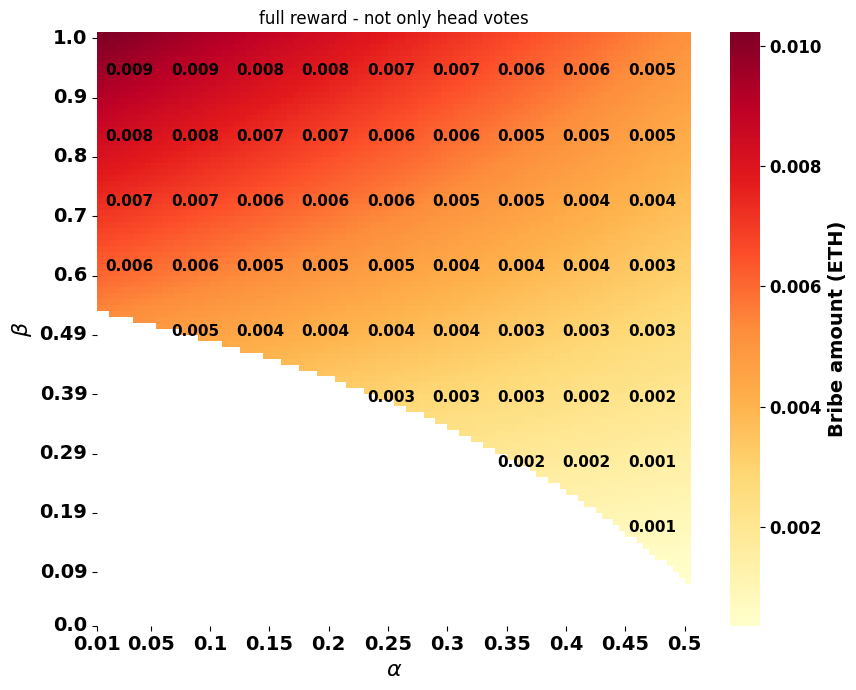

In [31]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)

# L = 2 # fork_lengths
# F0 = 2
# k = 0.1
# canonical_length = 2
# F = F0 * np.exp(-k * L)

bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):

        lhs = 2 * (1 - alpha) * (1 - beta)
        # lhs = F * (1 - beta) * (1 - alpha) * L + (1 - alpha) * canonical_length

        rhs = 0.4 + alpha + (1 - alpha) * beta
        # rhs = alpha * canonical_length + F * alpha * L + F * beta * (1 - alpha) * L

        if lhs < rhs:

            bribe[i, j] = (beta * (1 - alpha) * noOfValidators * attestation_reward_per_validator / 32)
            # bribe[i, j] = L * beta * (1 - alpha) * noOfValidators * attestation_reward_per_validator / 32



vmin_bribe = np.nanmin(bribe)
vmax_bribe = np.nanmax(bribe)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (ETH)"},
    vmin=vmin_bribe,
    vmax=vmax_bribe,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight='bold')
ax.set_ylabel(r"$\beta$", fontsize=16, fontweight='bold')

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight='bold')
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight='bold')

ax.invert_yaxis()

for i in range(5, len(beta_vals), 11):
    for j in range(5, len(alpha_vals), 11):
        value = bribe[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5, i + 0.5,
                f"{value:.3f}",
                ha='center',
                va='center',
                fontsize=11,      
                fontweight='bold', 
                color="black"
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
for lbl in cbar.ax.get_yticklabels():  
    lbl.set_fontweight('bold')
cbar.set_label("Bribe amount (ETH)", fontsize=14, fontweight='bold')
plt.setp(cbar.ax.get_yticklabels(), fontweight='bold')
plt.title("full reward - not only head votes")
plt.tight_layout()
#plt.savefig("PayToAttest_BribeAmount.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Only headvotes

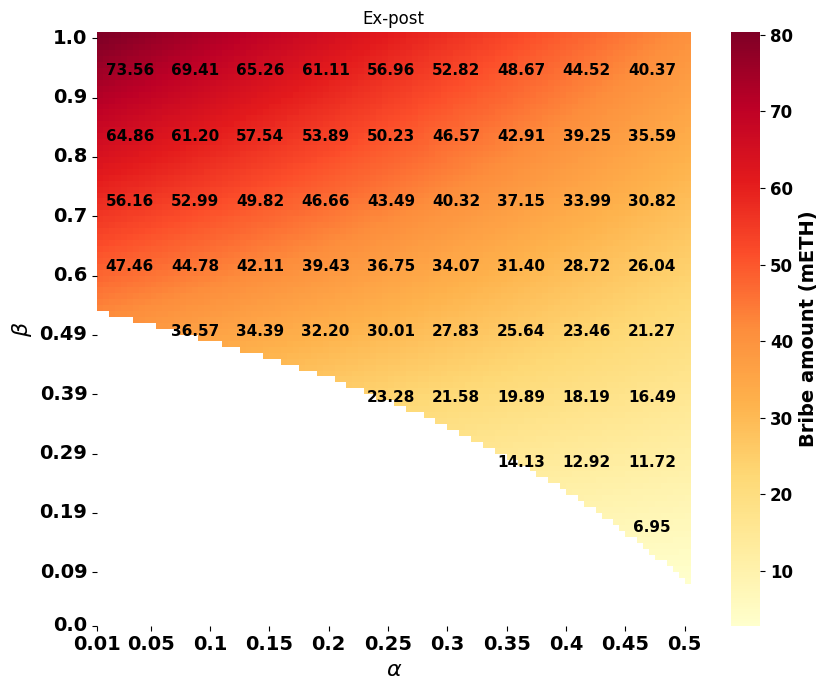

In [32]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)

head_vote_reward_per_validator = (W_h / 64) * 32 * b / 1e6  # 7*b/1e9 in mETH


bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):

        lhs = 2 * (1 - alpha) * (1 - beta)
        rhs = 0.4 + alpha + (1 - alpha) * beta

        if lhs < rhs:

            bribe[i, j] = (beta * (1 - alpha) * noOfValidators * head_vote_reward_per_validator / 32)


vmin_bribe = np.nanmin(bribe)
vmax_bribe = np.nanmax(bribe)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (ETH)"},
    vmin=vmin_bribe,
    vmax=vmax_bribe,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight='bold')
ax.set_ylabel(r"$\beta$", fontsize=16, fontweight='bold')

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight='bold')
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight='bold')

ax.invert_yaxis()

for i in range(5, len(beta_vals), 11):
    for j in range(5, len(alpha_vals), 11):
        value = bribe[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5, i + 0.5,
                f"{value:.2f}",
                ha='center',
                va='center',
                fontsize=11,      
                fontweight='bold', 
                color="black"
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
for lbl in cbar.ax.get_yticklabels():  
    lbl.set_fontweight('bold')
cbar.set_label("Bribe amount (mETH)", fontsize=14, fontweight='bold')
plt.setp(cbar.ax.get_yticklabels(), fontweight='bold')

plt.title("Ex-post")
plt.tight_layout()
#plt.savefig("PayToAttest_BribeAmount_onlyheadvotes.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### MEV line

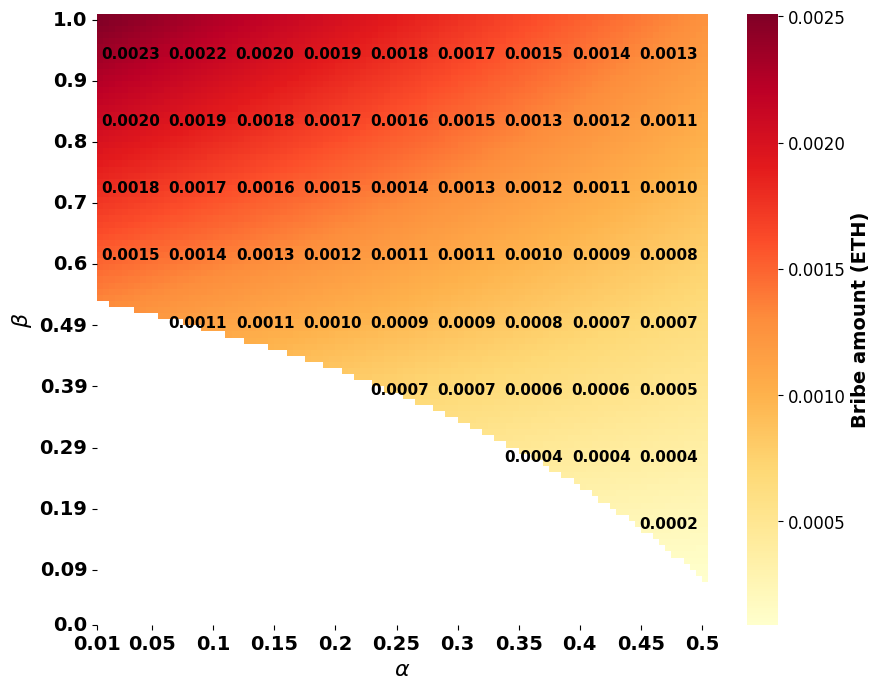

In [ ]:
plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (ETH)"},
    vmin=vmin_bribe,
    vmax=vmax_bribe,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight='bold')
ax.set_ylabel(r"$\beta$", fontsize=16, fontweight='bold')

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight='bold')
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight='bold')

ax.invert_yaxis()

for i in range(5, len(beta_vals), 11):
    for j in range(5, len(alpha_vals), 11):
        value = bribe[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5, i + 0.5,
                f"{value:.4f}",
                ha='center',
                va='center',
                fontsize=11,      
                fontweight='bold', 
                color="black"
            )

mev_per_slot_eth = 0.053 
CS = ax.contour(
    bribe,
    levels=[mev_per_slot_eth],
    colors="blue",
    linewidths=2,
    linestyles="solid",
    origin="upper"
)
ax.clabel(CS, fmt={mev_per_slot_eth: f"MEV={mev_per_slot_eth:.3f} ETH/slot"},
          inline=False, fontsize=12)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Bribe amount (ETH)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Ex-ante bribe amount heatmap

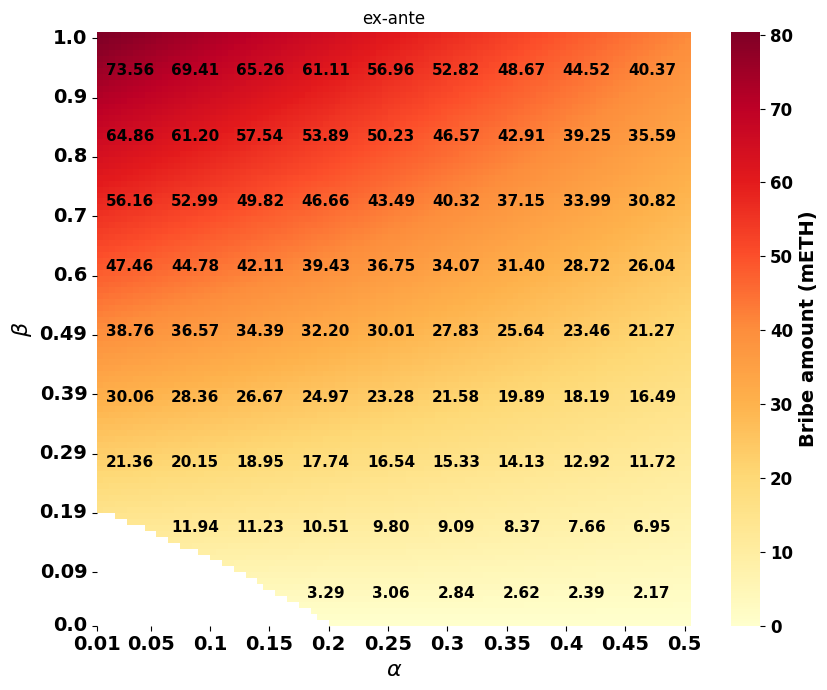

In [34]:
pboost = 0.4
a = 1.0
h = 1.0

alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals  = np.linspace(0.00, 1.00, 100)

head_vote_reward_per_validator = (W_h / 64) * 32 * b / 1e6   # mETH

y_thr = (h - pboost) / (a + 2.0*h)

bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):
        y = alpha + (1.0 - alpha) * beta
        success = (y > y_thr) and (0.0 <= beta <= 1.0)
        if success:
            bribe[i, j] = beta * (1 - alpha) * (noOfValidators / 32.0) * head_vote_reward_per_validator

vmin_bribe = np.nanmin(bribe)
vmax_bribe = np.nanmax(bribe)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (mETH) — ex-ante, head-only"},
    vmin=vmin_bribe, vmax=vmax_bribe,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight='bold')
ax.set_ylabel(r"$\beta$", fontsize=16, fontweight='bold')

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight='bold')
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight='bold')
ax.invert_yaxis()

for i in range(5, len(beta_vals), 11):
    for j in range(5, len(alpha_vals), 11):
        value = bribe[i, j]
        if not np.isnan(value):
            ax.text(j + 0.5, i + 0.5, f"{value:.2f}",
                    ha='center', va='center', fontsize=11, fontweight='bold', color="black")

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
for lbl in cbar.ax.get_yticklabels():
    lbl.set_fontweight('bold')
cbar.set_label("Bribe amount (mETH)", fontsize=14, fontweight='bold')
plt.setp(cbar.ax.get_yticklabels(), fontweight='bold')
plt.title("ex-ante")
plt.tight_layout()
plt.show()

## MEV

In [36]:
def mev_time_multiplier(t_sec: float) -> float:
    # cikk Eq.(1)-ből
    delta_pct = -1.99*t_sec**3 + 2.44*t_sec**2 + 32.5*t_sec + 40.77
    return 1.0 + delta_pct/100.0  # pl. t=2.78 -> ~2.07× baseline

def beta_min_expost_vec(alpha, pboost=0.4):
    # Eq3: beta* = (2 - 3α - pboost) / (3(1 - α)), [0,1] és NaN clamp
    num = 2.0 - 3.0*alpha - pboost
    den = 3.0*(1.0 - alpha)
    beta = num / den
    beta = np.where(den <= 0, np.nan, beta)
    beta = np.where(beta <= 0, 0.0, beta)
    beta = np.where(beta > 1.0, np.nan, beta)
    return beta

def beta_min_exante_vec(alpha, a=1.0, h=1.0, pboost=0.4):
    # Eq5 küszöb: y_thr = (h - pboost)/(a + 2h), beta* = (y_thr - α)/(1-α)
    y_thr = (h - pboost) / (a + 2.0*h)
    if y_thr <= 0:  return np.zeros_like(alpha)
    if y_thr >= 1:  return np.full_like(alpha, np.nan)
    den = (1.0 - alpha)
    beta = (y_thr - alpha) / den
    beta = np.where(den <= 0, np.nan, beta)
    beta = np.where(beta <= 0, 0.0, beta)
    beta = np.where(beta > 1.0, np.nan, beta)
    return beta

def add_mev_line_on_heatmap(ax, bribe_grid, alpha_vals, beta_vals,
                            mev_budget, label='MEV line', color='k'):
    """
    ax: a seaborn heatmap tengelye
    bribe_grid: (len(beta_vals), len(alpha_vals)) mátrix ugyanabban az egységben, mint mev_budget
    mev_budget: numerikus szint (ugyanabban az egységben, mint bribe_grid)
    """
    Xc = np.arange(len(alpha_vals)) + 0.5
    Yc = np.arange(len(beta_vals))  + 0.5
    XX, YY = np.meshgrid(Xc, Yc)

    cs1 = ax.contour(XX, YY, bribe_grid, levels=[mev_budget], colors='k', linewidths=3)
    cs2 = ax.contour(XX, YY, bribe_grid, levels=[mev_budget], colors='w', linewidths=1.5)
    proxy = Line2D([0], [0], color=color, lw=3, label=label)
    return proxy

def add_beta_star_curve(ax, alpha_vals, beta_vals, beta_star_of_alpha, label='β*', style='--', color='k', lw=2.5):
    j = np.arange(len(alpha_vals))
    beta_star = beta_star_of_alpha(alpha_vals) 
    i = np.interp(beta_star, beta_vals, np.arange(len(beta_vals)))
    ax.plot(j + 0.5, i + 0.5, linestyle=style, color=color, linewidth=lw, label=label)
    return Line2D([0], [0], linestyle=style, color=color, lw=lw, label=label)

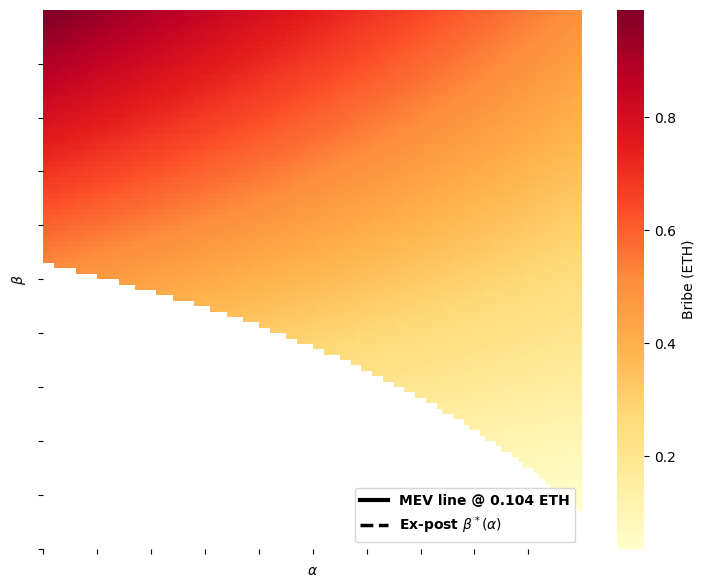

In [ ]:
baseline_mev_eth = 0.05     # atlagos nagyságrend / blokk
wait_t = 2.78               # MEV-time maximum (107%)  :contentReference[oaicite:1]{index=1}
mev_budget_eth = baseline_mev_eth * mev_time_multiplier(wait_t)

mev_legend = add_mev_line_on_heatmap(ax, bribe, alpha_vals, beta_vals,
                                     mev_budget=mev_budget_eth,
                                     label=f"MEV line @ {mev_budget_eth:.3f} ETH")

beta_legend = add_beta_star_curve(ax, alpha_vals, beta_vals,
                                  beta_star_of_alpha=lambda a: beta_min_expost_vec(a, pboost=0.4),
                                  label=r"Ex-post $\beta^*(\alpha)$",
                                  style='--', color='k', lw=2.5)

alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals  = np.linspace(0.00, 1.00, 100)
A, B = np.meshgrid(alpha_vals, beta_vals)
bribe = np.where(2*(1-A)*(1-B) < (0.4 + A + (1-A)*B), (1-A)*B, np.nan) 

plt.figure(figsize=(9,7))
ax = sns.heatmap(bribe, cmap="YlOrRd", mask=np.isnan(bribe),
                 square=True, xticklabels=np.round(alpha_vals[::10],2),
                 yticklabels=np.round(beta_vals[::-10],2),
                 cbar_kws={"label": "Bribe (ETH)"})
ax.set_xlabel(r"$\alpha$", fontweight='bold'); ax.set_ylabel(r"$\beta$", fontweight='bold')
ax.set_xticks(np.arange(0,len(alpha_vals),10)); ax.set_yticks(np.arange(0,len(beta_vals),10))
ax.invert_yaxis()


handles, labels = ax.get_legend_handles_labels()
handles.extend([mev_legend, beta_legend])
labels.extend([mev_legend.get_label(), beta_legend.get_label()])
leg = ax.legend(handles, labels, loc="lower right", frameon=True)
for t in leg.get_texts():
    t.set_fontweight('bold')

plt.draw()

#### PayToAttest — min bribery requiremen

where β* is a threshold value (the minimum β required for success)


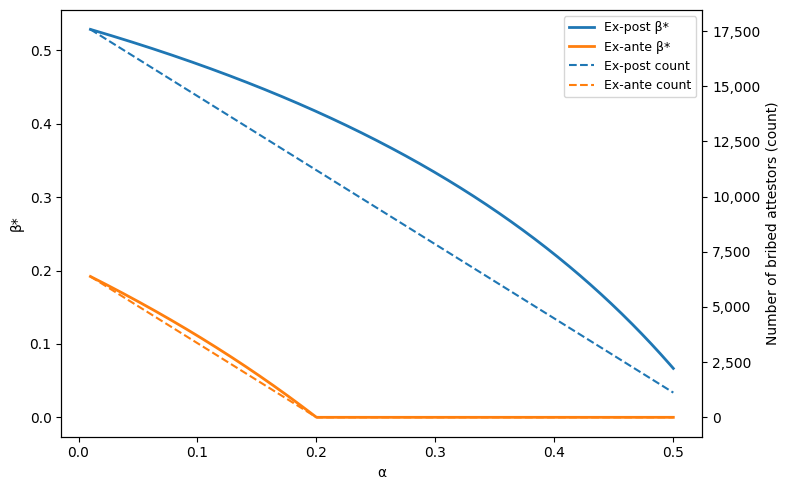

In [5]:
pboost = 0.4
attestors_per_slot = noOfValidators / 32.0
a, h = 1, 1  # ex-ante chain parameter

alpha = np.linspace(0.01, 0.5, 500)

def beta_min_expost(alpha, pboost=0.4):
    # Eq3: 2(1-alpha)(1-beta) <= pboost + alpha + (1 - alpha)beta  ==>  beta* = (2 - 3alpha - pboost) / (3(1 - alpha))
    num = 2.0 - 3.0*alpha - pboost
    den = 3.0*(1.0 - alpha)
    beta_star = num / den
    beta_star = np.where(beta_star <= 0, 0.0, beta_star)
    beta_star = np.where(beta_star > 1.0, np.nan, beta_star)
    return beta_star

def beta_min_exante(alpha, a=1, h=1, pboost=0.4):
    # Eq5: (a + h) * (alpha + (1 - alpha)beta) + pboost > h * (1 - (alpha + (1 - alpha)beta))
    # y = alpha + (1 - alpha)beta ==> (a + 2h) * y > h - pboost ==> y_thr = (h - pboost) / (a + 2h)
    y_thr = (h - pboost) / (a + 2.0*h)
    if y_thr <= 0:
        return np.zeros_like(alpha)
    if y_thr >= 1.0:
        return np.full_like(alpha, np.nan)
    den = (1.0 - alpha)
    beta_star = (y_thr - alpha) / den
    beta_star = np.where(beta_star <= 0, 0.0, beta_star)
    beta_star = np.where(beta_star > 1.0, np.nan, beta_star)
    return beta_star

beta_expost = beta_min_expost(alpha, pboost=pboost)
beta_exante = beta_min_exante(alpha, a=a, h=h, pboost=pboost)

count_expost = (1.0 - alpha) * beta_expost * attestors_per_slot
count_exante = (1.0 - alpha) * beta_exante * attestors_per_slot

print("where β* is a threshold value (the minimum β required for success)")

fig, ax1 = plt.subplots(figsize=(8, 5))

l1, = ax1.plot(alpha, beta_expost, label="Ex-post β*", linewidth=2)
l2, = ax1.plot(alpha, beta_exante, label="Ex-ante β*", linewidth=2)
ax1.set_xlabel("α")
ax1.set_ylabel("β*")

ax2 = ax1.twinx()
l3, = ax2.plot(alpha, count_expost, linestyle="--", color=l1.get_color(), label="Ex-post count")
l4, = ax2.plot(alpha, count_exante, linestyle="--", color=l2.get_color(), label="Ex-ante count")
ax2.set_ylabel("Number of bribed attestors (count)")
ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

lines = [l1, l2, l3, l4]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="upper right", fontsize=9)

plt.tight_layout()
plt.show()


### PayToAttest cost vs time

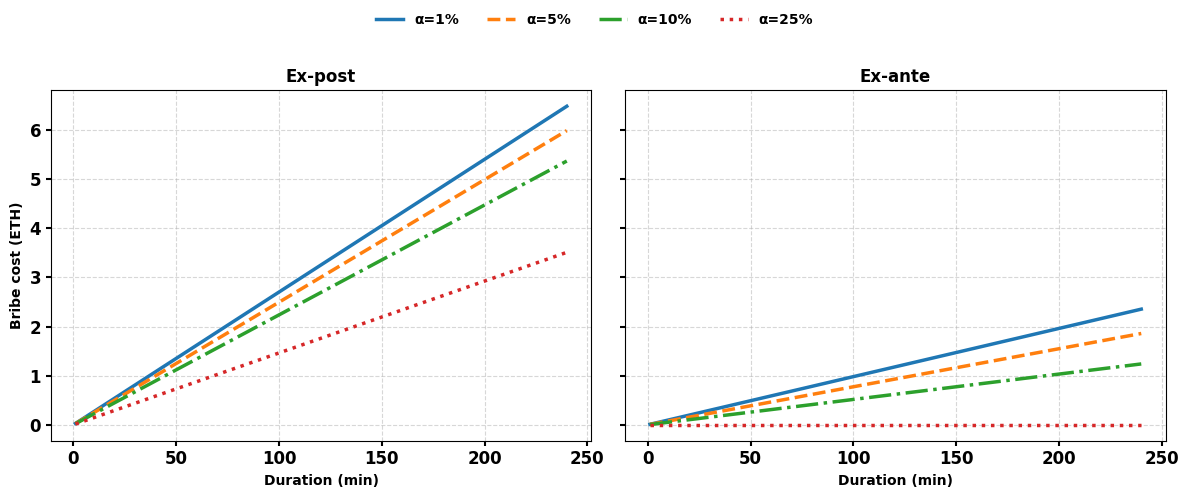

In [ ]:
attestors_per_slot = noOfValidators / 32
pboost = 0.4                     
slot_seconds = 12                   
a, h = 1, 1             
att_reward_eth = (b / 64.0) * 57.0 / 1e9  

def beta_min_expost(alpha, pboost=0.4):
    # Eq3: beta* = (2 - 3alpha - pboost) / (3(1 - alpha))
    num = 2.0 - 3.0*alpha - pboost
    den = 3.0*(1.0 - alpha)
    if den <= 0: 
        return np.nan
    beta_star = num / den
    if beta_star <= 0:  return 0.0
    if beta_star > 1.0: return np.nan
    return beta_star

def beta_min_exante(alpha, a=1, h=1, pboost=0.4):
    # Eq5: y > (h - pboost)/(a + 2h), y = alpha + (1 - alpha)beta  ->  beta* = (y_thr - alpha)/(1 - alpha)
    y_thr = (h - pboost) / (a + 2.0*h)
    if y_thr <= 0:  return 0.0
    if y_thr >= 1:  return np.nan
    den = (1.0 - alpha)
    if den <= 0:   return np.nan
    beta_star = (y_thr - alpha) / den
    if beta_star <= 0:  return 0.0
    if beta_star > 1.0: return np.nan
    return beta_star

def per_slot_cost(alpha, mode='expost'):
    beta_star = beta_min_expost(alpha, pboost) if mode=='expost' else beta_min_exante(alpha, a, h, pboost)
    if not np.isfinite(beta_star): return np.nan
    return (1.0 - alpha) * beta_star * attestors_per_slot * att_reward_eth

minutes = np.arange(1, 241)
slots_for = np.ceil((minutes*60) / slot_seconds)

alphas = [0.01, 0.05, 0.10, 0.25]

linestyles = ['-', '--', '-.', ':']
colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
style_map = {a: {'ls': linestyles[i % len(linestyles)],
                 'color': colors[i % len(colors)]}
             for i, a in enumerate(alphas)}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for a_i in alphas:
    c_expost = per_slot_cost(a_i, 'expost')
    cost_expost = slots_for * c_expost
    axes[0].plot(
        minutes, cost_expost,
        label=f"α={a_i:.0%}",
        linestyle=style_map[a_i]['ls'],
        color=style_map[a_i]['color'],
        linewidth=2.5
    )
axes[0].set_title("Ex-post", fontweight='bold')
axes[0].set_xlabel("Duration (min)", fontweight='bold')
axes[0].set_ylabel("Bribe cost (ETH)", fontweight='bold')
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

for a_i in alphas:
    c_exante = per_slot_cost(a_i, 'exante')
    cost_exante = slots_for * c_exante
    axes[1].plot(
        minutes, cost_exante,
        label=f"α={a_i:.0%}",
        linestyle=style_map[a_i]['ls'], 
        color=style_map[a_i]['color'], 
        linewidth=2.5
    )
axes[1].set_title("Ex-ante", fontweight='bold')
axes[1].set_xlabel("Duration (min)", fontweight='bold')
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

for ax in axes:
    ax.tick_params(axis='both', labelsize=12, width=1.5)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

legend_lines = [Line2D([0], [0],
                       linestyle=style_map[a]['ls'],
                       color=style_map[a]['color'],
                       linewidth=2.5)
                for a in alphas]
leg = fig.legend(legend_lines, [f"α={a:.0%}" for a in alphas],
                 loc="upper center", ncol=len(alphas), frameon=False)
for txt in leg.get_texts():
    txt.set_fontweight('bold')

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()

# Pay To Exit


In [7]:
def getMaxIssuancePerYear(noOfValidators):
    return 940.8659 * math.sqrt(noOfValidators)


def getAPR(noOfValidators):
    return 2940.21 / math.sqrt(noOfValidators)

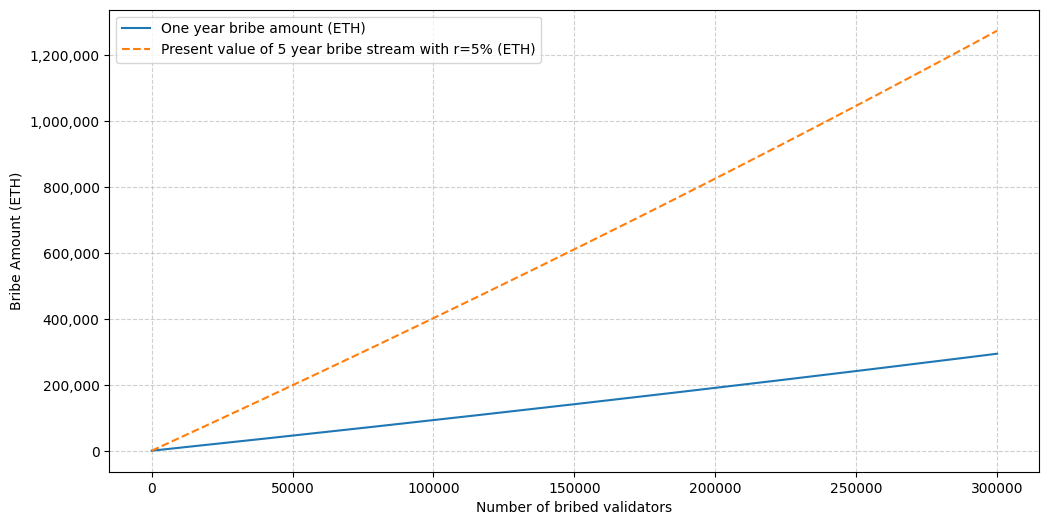

In [ ]:
noOfBribedValidators = 300000

discount_rate = 0.05
years = 5           

oneYearRewards = [
    32 * getAPR(i) / 100
    for i in range(noOfValidators, noOfValidators - noOfBribedValidators, -1)
]
bribeAmounts = np.cumsum(oneYearRewards) 

# PV = A * [1 - (1+r)^-Y] / r
if discount_rate == 0:
    pv_factor = years
else:
    pv_factor = (1 - (1 + discount_rate) ** (-years)) / discount_rate

bribePresentValue = bribeAmounts * pv_factor  # ETH

plt.figure(figsize=(12, 6))
plt.plot(bribeAmounts, label="One year bribe amount (ETH)")
plt.plot(
    bribePresentValue,
    label=f"Present value of {years} year bribe stream with r={discount_rate:.0%} (ETH)",
    linestyle="--",
)
plt.xlabel("Number of bribed validators")
plt.ylabel("Bribe Amount (ETH)")
plt.ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
#plt.savefig("payToExitBribeAmounts.pdf", format="pdf", bbox_inches="tight")
plt.show()

* Monotonic growth: bribing more validators -> higher annual bribe outlay -> proportionally higher present value (PV).
* Sensitivity: higher discount rate (r) -> lower PV; longer time horizon (Y) -> higher PV, since future payments accumulate more weight.
* Interpretation: PV represents the “today’s cost” of a multi-year bribery commitment; this is the relevant figure for comparing against potential returns (MEV gains) when assessing attack profitability.

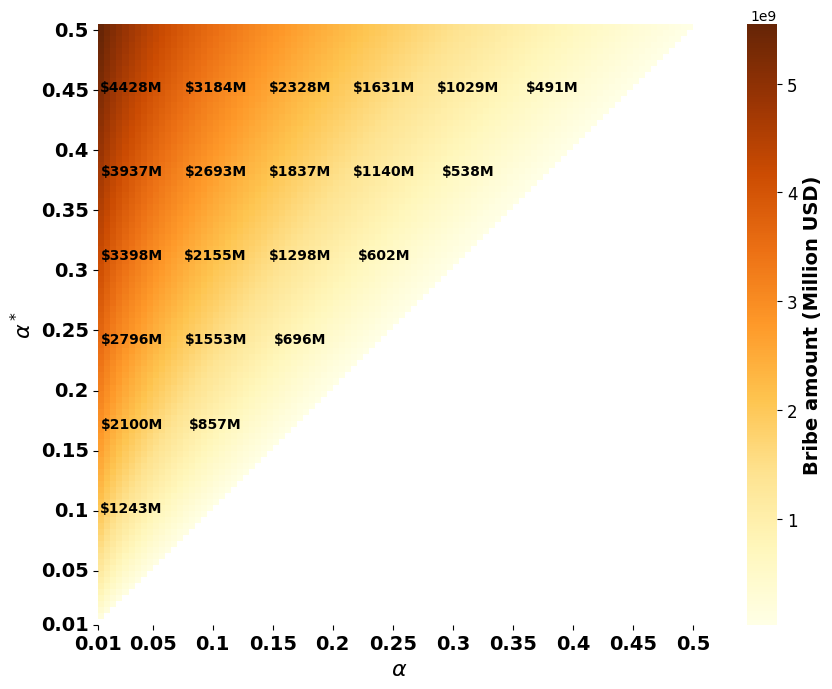

In [ ]:
interest_rate = 0.05

def compute_bribe_cost(alpha, alpha_star):
    if alpha_star < alpha:
        return np.nan

    current_validators = int(alpha * noOfValidators)
    target_validators = int(alpha_star * noOfValidators)
    bribed = target_validators - current_validators

    if bribed <= 0:
        return np.nan

    one_year_rewards = [32 * getAPR(i) / 100 for i in range(current_validators, current_validators + bribed)]
    bribe_amounts = np.cumsum(one_year_rewards)
    bribe_with_interest = bribe_amounts * (1 + interest_rate) ** years

    return bribe_with_interest[-1]


alpha_vals = np.linspace(0.01, 0.5, 100)
alpha_star_vals = np.linspace(0.01, 0.5, 100)


bribe_cost = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        bribe_cost[i, j] = compute_bribe_cost(alpha, alpha_star)


eth_usd_rate = 3668.77  # USD / ETH (2025-04-01 árfolyam)

bribe_cost_usd = bribe_cost * eth_usd_rate

vmin = np.nanmin(bribe_cost_usd)
vmax = np.nanmax(bribe_cost_usd)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    bribe_cost_usd,
    cmap="YlOrBr",
    mask=np.isnan(bribe_cost_usd),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Bribe amount (Million USD)"},
    vmin=vmin,
    vmax=vmax,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight='bold')
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight='bold')

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight='bold')
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight='bold')

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 14):
    for j in range(5, len(alpha_vals), 14):
        value = bribe_cost_usd[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5, i + 0.5,
                f"${value/1e6:.0f}M", 
                ha='center',
                va='center',
                fontsize=10,
                fontweight='bold',
                color='black'
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Bribe amount (Million USD)", fontsize=14, fontweight='bold')

plt.tight_layout()
#plt.savefig("PayToExit_BribeHeatmap.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Pay to exit: attack duration

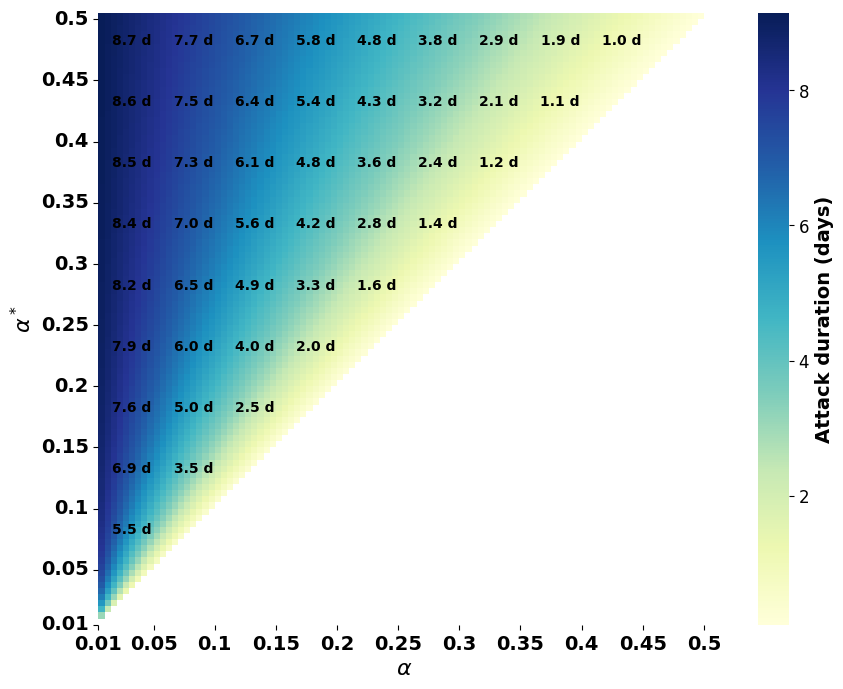

In [ ]:
validators_per_block = 16
block_time_sec = 12    

alpha_vals = np.linspace(0.01, 0.5, 100)
alpha_star_vals = np.linspace(0.01, 0.5, 100)

attack_time_days = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        if alpha_star > alpha:
            delta_validators = math.ceil(noOfValidators * (alpha_star - alpha) / alpha_star)

            blocks_needed = delta_validators / validators_per_block
            time_days = (blocks_needed * block_time_sec) / 86400.0
            attack_time_days[i, j] = time_days

vmin = np.nanmin(attack_time_days)
vmax = np.nanmax(attack_time_days)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)
yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    attack_time_days,
    cmap="YlGnBu",
    mask=np.isnan(attack_time_days),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Attack duration (days)"},
    vmin=vmin, vmax=vmax,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight='bold')
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight='bold')

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight='bold')
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight='bold')

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 10):
    for j in range(5, len(alpha_vals), 10):
        value = attack_time_days[i, j]
        if not np.isnan(value):
            txt = f"{value:.1f} d" if value < 100 else f"{value:.0f} d"
            ax.text(j + 0.5, i + 0.5, txt,
                    ha='center', va='center', fontsize=10, fontweight='bold', color='black')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Attack duration (days)", fontsize=14, fontweight='bold')

plt.tight_layout()
#plt.savefig("PayToExit_AttackDuration_days.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Pay-To-Exit gas cost vs number of blocks

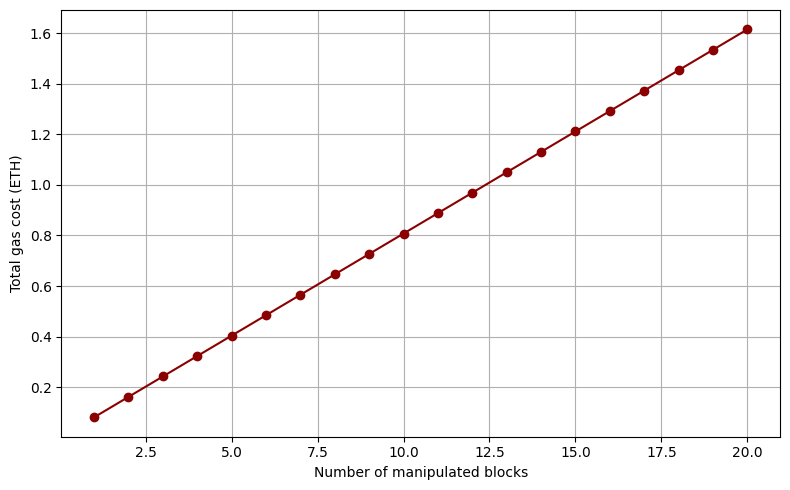

In [15]:
validators_per_block = 32
offer_gas = 60000
take_gas = 1150660
total_gas_per_validator = offer_gas + take_gas

gwei_price = 2.084 / 1e9
eth_usd_price = 3668.77

blocks = list(range(1, 21))
eth_costs = []
usd_costs = []

for b in blocks:
    total_validators = b * validators_per_block
    total_gas = total_validators * total_gas_per_validator
    eth_cost = total_gas * gwei_price
    usd_cost = eth_cost * eth_usd_price
    eth_costs.append(eth_cost)
    usd_costs.append(usd_cost)

plt.figure(figsize=(8, 5))
plt.plot(blocks, eth_costs, marker="o", color="darkred")
plt.xlabel("Number of manipulated blocks")
plt.ylabel("Total gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

- the total gas cost increases with the number of blocks a briber attempts to manipulate in order to force a validator to exit the system
- each block requires bribing 32 validators using both offerBribe() and takeBribe() functions
- making the cost grow linearly with the number of targeted blocks


### Pay-To-Exit cost and block duration


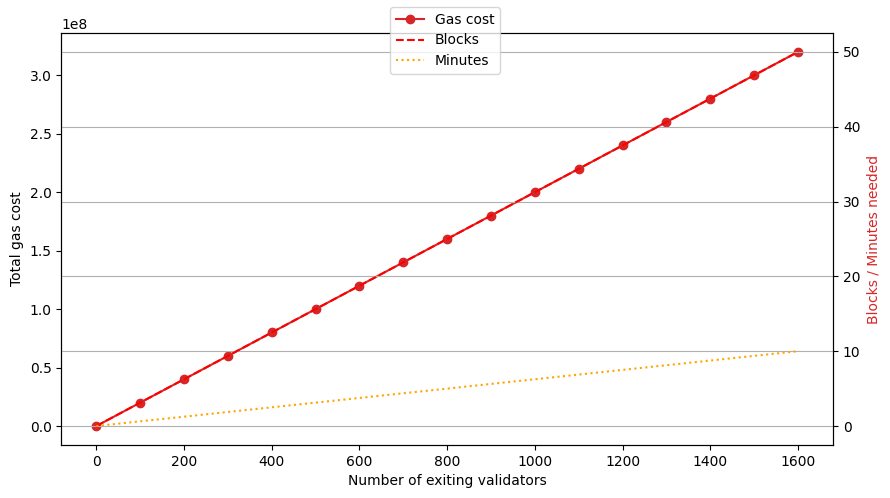

In [17]:
validators_to_exit = list(range(0, 1601, 100))
gas_per_validator = 200_000
validators_per_block = 32
block_time_seconds = 12

total_gas = [v * gas_per_validator for v in validators_to_exit]
blocks_needed = [v / validators_per_block for v in validators_to_exit]
time_minutes = [b * block_time_seconds / 60 for b in blocks_needed]

fig, ax1 = plt.subplots(figsize=(9, 5))

color = "tab:red"
ax1.set_xlabel("Number of exiting validators")
ax1.set_ylabel("Total gas cost")
ax1.plot(validators_to_exit, total_gas, color=color, marker="o", label="Gas cost")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()

ax2.set_ylabel("Blocks / Minutes needed", color=color)
ax2.plot(validators_to_exit, blocks_needed, color="red", linestyle="--", label="Blocks")
ax2.plot(
    validators_to_exit, time_minutes, color="orange", linestyle=":", label="Minutes"
)
ax2.tick_params(axis="y")

fig.tight_layout()
fig.legend(loc="upper center")
plt.grid(True)
plt.show()

# Pay to bias

### gas cost vs number of tail slots

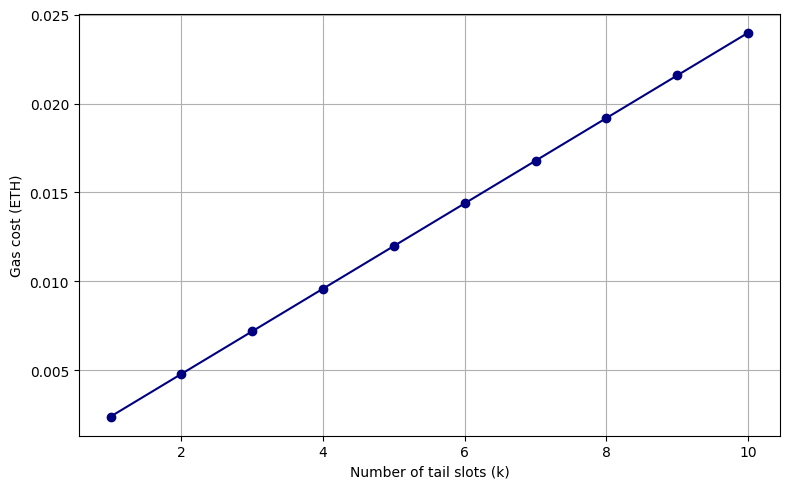

In [18]:
tail_slots = list(range(1, 11))

base_gas_per_verification = 1150660  # from Table2

gas_costs = [k * base_gas_per_verification for k in tail_slots]

eth_usd_price = 3668.77
gwei_price = 2.084 / 1e9  # ETH
usd_costs = [gas * gwei_price * eth_usd_price for gas in gas_costs]
eth_costs = [gas * gwei_price for gas in gas_costs]


plt.figure(figsize=(8, 5))
plt.plot(tail_slots, eth_costs, marker="o", color="navy")
plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

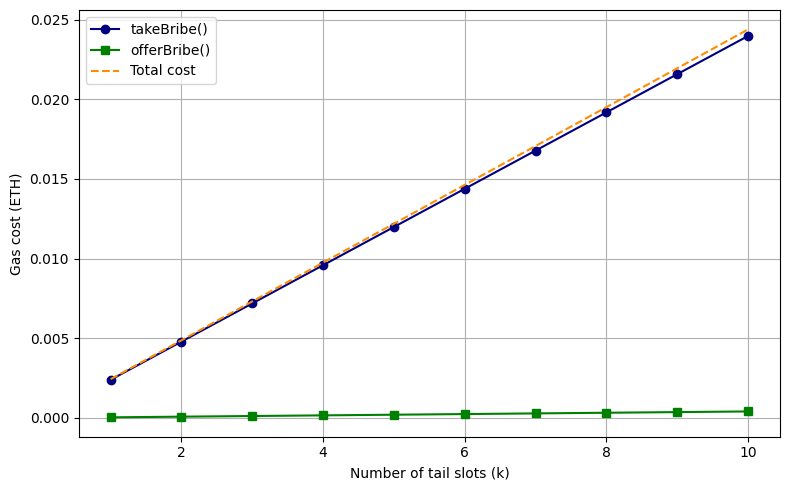

In [19]:
tail_slots = list(range(1, 11))

gas_take_bribe = 1150660
gas_offer_bribe = 19678

gwei_price_eth = 2.084 / 1e9
eth_usd_price = 3668.77

eth_cost_take = [k * gas_take_bribe * gwei_price_eth for k in tail_slots]
eth_cost_offer = [k * gas_offer_bribe * gwei_price_eth for k in tail_slots]
eth_cost_total = [take + offer for take, offer in zip(eth_cost_take, eth_cost_offer)]

plt.figure(figsize=(8, 5))
plt.plot(tail_slots, eth_cost_take, label="takeBribe()", marker="o", color="navy")
plt.plot(tail_slots, eth_cost_offer, label="offerBribe()", marker="s", color="green")
plt.plot(
    tail_slots, eth_cost_total, label="Total cost", linestyle="--", color="darkorange"
)

plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Histogram


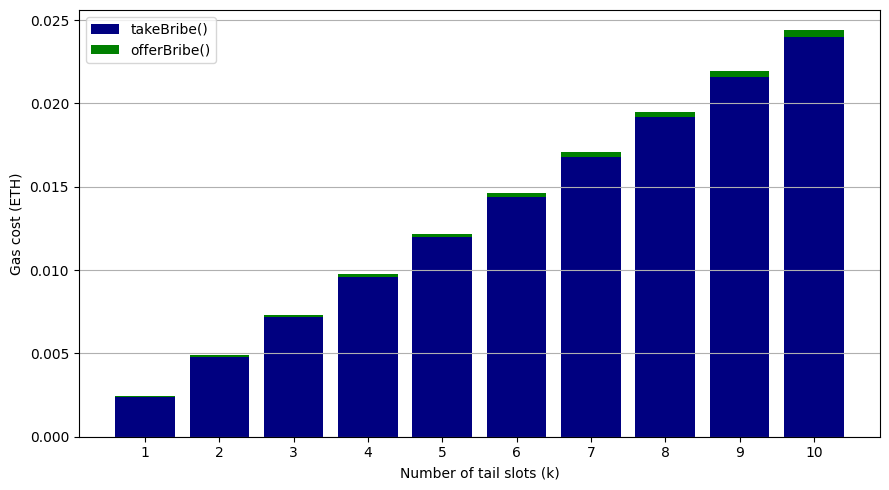

In [20]:
tail_slots = list(range(1, 11))

gas_take_bribe = 1150660
gas_offer_bribe = 19678

gwei_price_eth = 2.084 / 1e9

eth_cost_take = [k * gas_take_bribe * gwei_price_eth for k in tail_slots]
eth_cost_offer = [k * gas_offer_bribe * gwei_price_eth for k in tail_slots]

x = np.arange(len(tail_slots))

plt.figure(figsize=(9, 5))
plt.bar(x, eth_cost_take, label="takeBribe()", color="navy")
plt.bar(x, eth_cost_offer, bottom=eth_cost_take, label="offerBribe()", color="green")

plt.xticks(x, tail_slots)
plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

- shows how the total gas cost increases as the attacker attempts to influence more tail slots
- for each slot the attacker must call both offerBribe() and takeBribe()
- which together make the cost grow linearly with the number of slots


#### Gas Cost vs. Published Slot Ratio


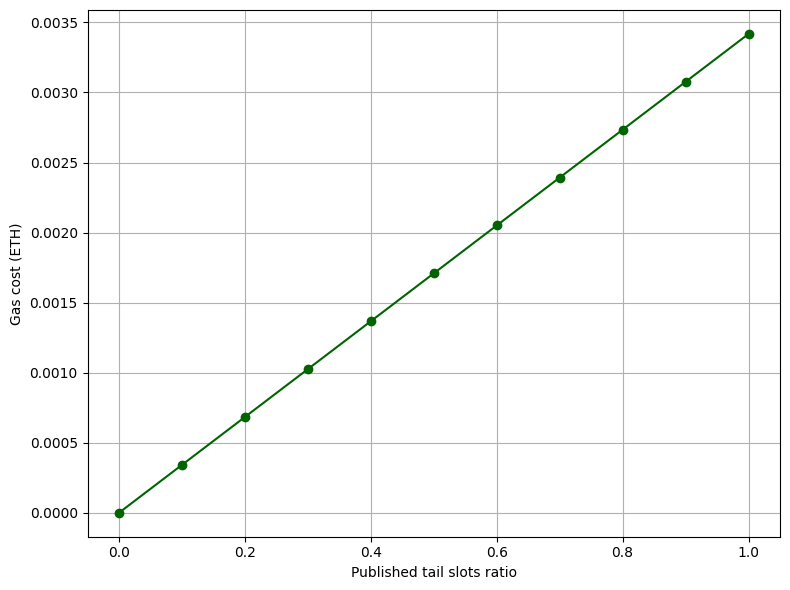

In [21]:
k = 10  # tail slot
gas_per_slot = 93156
gas_price_gwei = 3.66877
gwei_to_eth = 1e-9

ratios = np.linspace(0, 1, 11)

published_slots = ratios * k

total_gas = published_slots * gas_per_slot
total_eth_cost = total_gas * gas_price_gwei * gwei_to_eth

plt.figure(figsize=(8, 6))
plt.plot(ratios, total_eth_cost, marker="o", color="darkgreen")
plt.xlabel("Published tail slots ratio")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Countermeasures

In [23]:
date_range = pd.date_range(start="2020-01-01", end="2025-01-01", freq="D")
num_days = len(date_range)

eth_supply = 110 + 0.005 * (pd.Series(range(num_days)) + (np.random.randn(num_days) * 0.2).cumsum())
eth_supply = eth_supply.round(3)

price = (2000 + (np.sin(np.linspace(0, 20, num_days)) * 200) + (np.random.randn(num_days) * 100).cumsum())
price = pd.Series(price).clip(lower=100)

df = pd.DataFrame({"date": date_range, "eth_supply_millions": eth_supply, "eth_usd_price": price})
df["eth_supply"] = df["eth_supply_millions"] * 1e6  
df["eth_inflation"] = df["eth_supply"].pct_change()
df["price_return"] = df["eth_usd_price"].pct_change()
df.dropna(inplace=True)
df["eth_inflation_percent"] = df["eth_inflation"] * 100
print(df.tail())

           date  eth_supply_millions  eth_usd_price   eth_supply  \
1823 2024-12-28              119.210    4745.940106  119210000.0   
1824 2024-12-29              119.214    4732.871950  119214000.0   
1825 2024-12-30              119.219    4764.581019  119219000.0   
1826 2024-12-31              119.222    4713.050459  119222000.0   
1827 2025-01-01              119.227    4849.175097  119227000.0   

      eth_inflation  price_return  eth_inflation_percent  
1823       0.000059     -0.017127               0.005872  
1824       0.000034     -0.002754               0.003355  
1825       0.000042      0.006700               0.004194  
1826       0.000025     -0.010815               0.002516  
1827       0.000042      0.028882               0.004194  


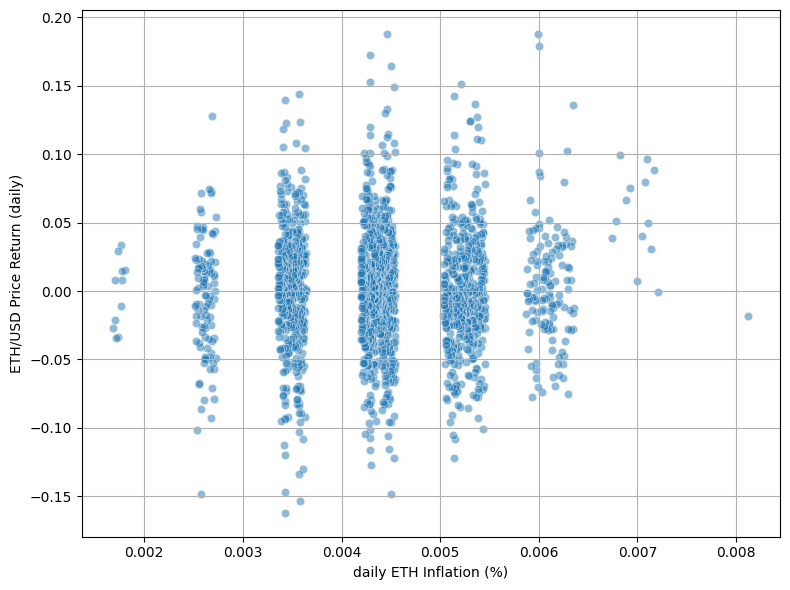

Korreláció: 0.0371
                            OLS Regression Results                            
Dep. Variable:           price_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.521
Date:                Mon, 25 Aug 2025   Prob (F-statistic):              0.113
Time:                        19:24:30   Log-Likelihood:                 3085.8
No. Observations:                1827   AIC:                            -6168.
Df Residuals:                    1825   BIC:                            -6157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0064   

In [24]:
import statsmodels.api as sm

plt.figure(figsize=(8, 6))
sns.scatterplot(x="eth_inflation_percent", y="price_return", data=df, alpha=0.5)
plt.xlabel("daily ETH Inflation (%)")
plt.ylabel("ETH/USD Price Return (daily)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
correlation = df["eth_inflation"].corr(df["price_return"])
print(f"Korreláció: {correlation:.4f}")

# Linear regression
X = sm.add_constant(df["eth_inflation"])
y = df["price_return"]
model = sm.OLS(y, X).fit()
print(model.summary())

### ETH/USD Price vs Issuance Rate

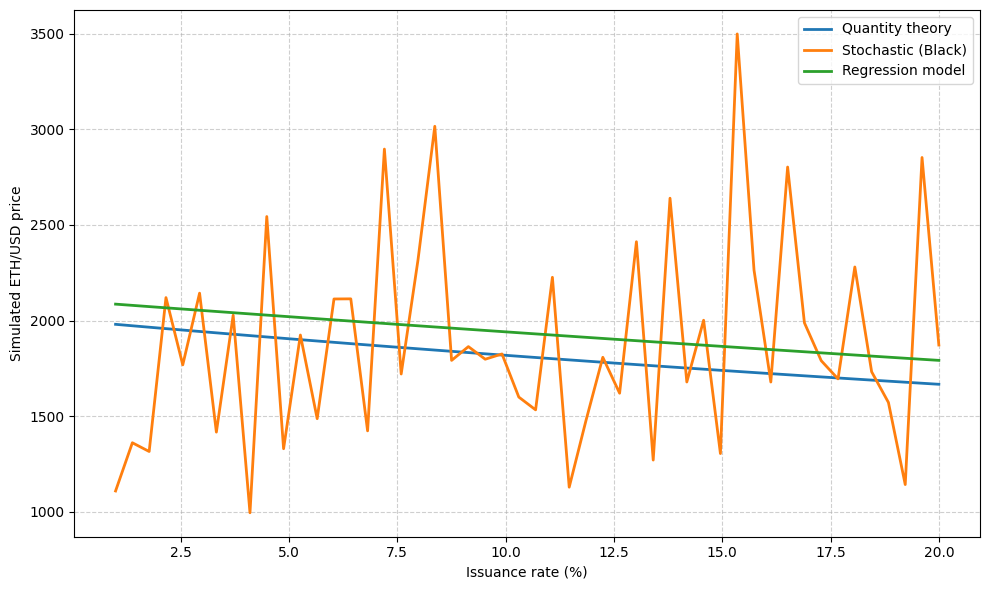

In [25]:
initial_price = 2000  
issuance_rates = np.linspace(0.01, 0.2, 50) 

# 1. Quantity theory of money (MV = PY) model
def quantity_theory_model(M0=100, V=5, Y=500):
    prices = []
    for i_rate in issuance_rates:
        M = M0 * (1 + i_rate) 
        P = (M * V) / Y        
        eth_price = initial_price * (1 / P)  # ETH/USD 
        prices.append(eth_price)
    return prices

# 2. Stochastic modell (Black)
def stochastic_black_model(mu=0.08, sigma=0.3, T=1, dt=1/252):
    time_grid = np.arange(0, T, dt)
    final_prices = []
    for pi in issuance_rates:
        price = initial_price
        for _ in time_grid:
            dW = np.random.normal(0, np.sqrt(dt))
            price *= np.exp((mu - pi - 0.5 * sigma**2) * dt + sigma * dW)
        final_prices.append(price)
    return final_prices

# 3.Regression model
def regression_model(beta_0=0.05, beta_1=-0.8, T=1):
    log_returns = beta_0 + beta_1 * issuance_rates
    prices = initial_price * np.exp(log_returns * T)
    return prices

qt_prices = quantity_theory_model()
stoch_prices = stochastic_black_model()
reg_prices = regression_model()

df = pd.DataFrame({
    "Issuance Rate (%)": issuance_rates * 100,
    "QuantityTheory": qt_prices,
    "StochasticModel": stoch_prices,
    "RegressionModel": reg_prices
})
#print(df.round(2))

plt.figure(figsize=(10, 6))
plt.plot(issuance_rates * 100, qt_prices, label="Quantity theory", linewidth=2)
plt.plot(issuance_rates * 100, stoch_prices, label="Stochastic (Black)", linewidth=2)
plt.plot(issuance_rates * 100, reg_prices, label="Regression model", linewidth=2)
plt.xlabel("Issuance rate (%)")
plt.ylabel("Simulated ETH/USD price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Makroökonómiai háttér / issuance policy hatása ETH árfolyamra:

– Három modell (Quantity theory, Stochastic, Regression) összehasonlítása
* Mindegyik az (kiadás) issuance rate növekedésével egyre alacsonyabb ETH/USD árat jelez
* Mutatja, hogy különböző elméleti és empirikus megközelítések is ugyanabba az irányba mutatnak

* Monotónia: magasabb issuance → alacsonyabb ETH ár
* Modellek eltérése:
    * Quantity theory -> legegyszerűbb, sima fordított arány
    * Stochastic (Black) -> volatilitás hatását is mutatja, szóródás lehetséges
    * Regression -> adatvezérelt becslés, empirikus alapon

– Értelmezés: issuance policy közvetlenül meghatározza az ETH inflációs árfolyamát

### ETH/USD price - time graph

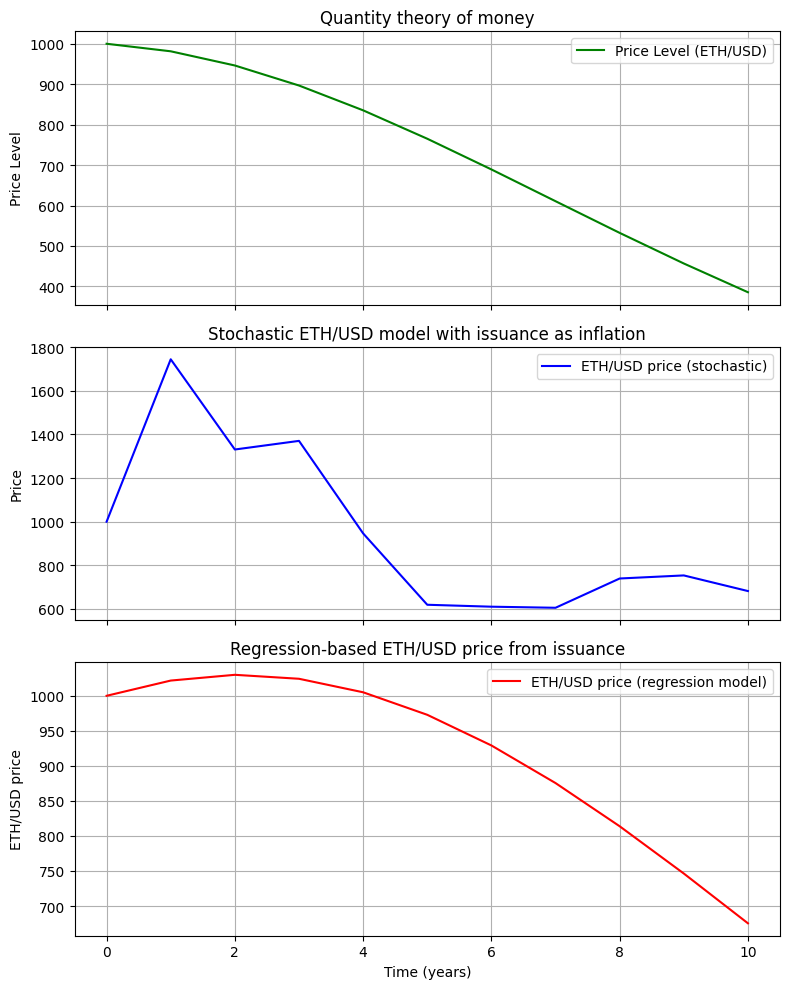

In [26]:
initial_price = 1000
years = 10
time = np.arange(0, years + 1)

issuance_rate = np.linspace(0.01, 0.10, len(time))

def quantity_theory(M0 = 100, V = 1, Y = 100):
    prices = []
    for i, pi in enumerate(issuance_rate):
        M = M0 * (1 + pi) ** i
        P = (M * V) / Y
        price = initial_price * (1 / P)
        prices.append(price)
    return prices

def stochastic_model(mu = 0.05, sigma = 0.2):
    dt = 1
    price = initial_price
    prices = [price]
    for i in range(1, len(time)):
        pi = issuance_rate[i]
        dW = np.random.normal(0, np.sqrt(dt))
        price *= np.exp((mu - pi - 0.5 * sigma**2) * dt + sigma * dW)
        prices.append(price)
    return prices

def regression_model(beta_0 = 0.05, beta_1 = -1.5):
    log_returns = beta_0 + beta_1 * issuance_rate
    prices = [initial_price]
    for i in range(1, len(time)):
        new_price = prices[-1] * np.exp(log_returns[i])
        prices.append(new_price)
    return prices

qt_prices = quantity_theory()
stoch_prices = stochastic_model()
reg_prices = regression_model()

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(time, qt_prices, color='green', label='Price Level (ETH/USD)')
axs[0].set_title("Quantity theory of money")
axs[0].set_ylabel("Price Level")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(time, stoch_prices, color='blue', label='ETH/USD price (stochastic)')
axs[1].set_title("Stochastic ETH/USD model with issuance as inflation")
axs[1].set_ylabel("Price")
axs[1].grid(True)
axs[1].legend()

axs[2].plot(time, reg_prices, color='red', label='ETH/USD price (regression model)')
axs[2].set_title("Regression-based ETH/USD price from issuance")
axs[2].set_xlabel("Time (years)")
axs[2].set_ylabel("ETH/USD price")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

Három modell időfüggő árfolyam-szimulációja:
* Az ár alakulását mutatja 10 éven át különböző módszerekkel
* Issuance itt inflációként jelenik meg, ami hosszú távon lefelé nyomja az ETH/USD árat


* Quantity theory: tisztán elméleti, determinisztikus csökkenés az infláció miatt
* Stochastic modell: random zaj is hozzáadva → volatilitást és lehetséges eltérő pályákat mutat
* Regression modell: empirikus adatokból kiindulva becsüli a pályát; meredekebb zuhanás, ha issuance magas


* mindhárom modell megerősíti, hogy hosszabb időtávon az issuance (infláció) erősen csökkenti az ETH árát

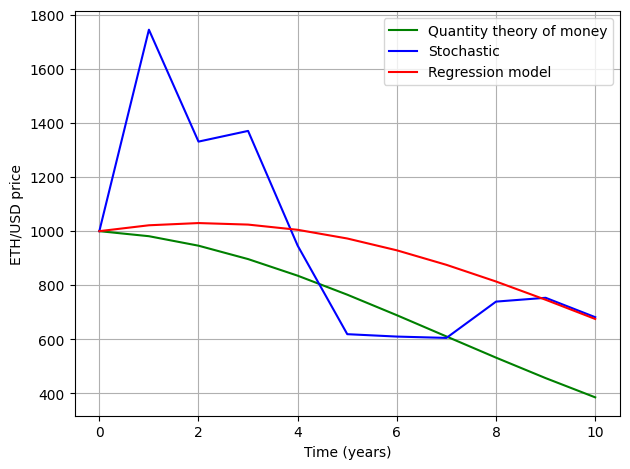

In [27]:
plt.plot(time, qt_prices, color='green', label='Quantity theory of money')
plt.plot(time, stoch_prices, color='blue', label='Stochastic')
plt.plot(time, reg_prices, color='red', label='Regression model')
plt.xlabel("Time (years)")
plt.ylabel("ETH/USD price")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()